# open pose

In [48]:
import argparse
import os.path as osp

import torch
from torch import Tensor

from pathlib import Path
import cv2
import numpy as np


from time import time
from PIL import Image
from torchvision.transforms import transforms

from models.model import ViTPose
from utils.visualization import draw_points_and_skeleton, joints_dict
from utils.dist_util import get_dist_info, init_dist
from utils.top_down_eval import keypoints_from_heatmaps

__all__ = ['inference']
            
            
@torch.no_grad()
def inference(img_paths: Path, img_size: tuple[int, int],
              model_cfg: dict, ckpt_path: Path, device: torch.device, save_result: bool=True) -> np.ndarray:
    
    # Prepare model
    vit_pose = ViTPose(model_cfg)
    
   
    ckpt = torch.load(ckpt_path)
    if 'state_dict' in ckpt:
        vit_pose.load_state_dict(ckpt['state_dict'])
    else:
        vit_pose.load_state_dict(ckpt)
    vit_pose.to(device)
    print(f">>> Model loaded: {ckpt_path}")
    
    for i, image_path in enumerate(img_paths):
        # Prepare input data
        print(image_path)
        try:
            img = Image.open(image_path).convert('RGB')
        except:
            img = Image.open(image_path)
        print(img)
        org_w, org_h = img.size
        print(i, image_path)
        print(f">>> Original image size: {org_h} X {org_w} (height X width)")
        print(f">>> Resized image size: {img_size[1]} X {img_size[0]} (height X width)")
        print(f">>> Scale change: {org_h/img_size[1]}, {org_w/img_size[0]}")
        try:
            img_tensor = transforms.Compose (
                [transforms.Resize((img_size[1], img_size[0])),
                 transforms.ToTensor()]
            )(img).unsqueeze(0).to(device)
        except:
            continue

        # Feed to model
        tic = time()
        heatmaps = vit_pose(img_tensor).detach().cpu().numpy() # N, 17, h/4, w/4
        
        elapsed_time = time()-tic
        print(f">>> Output size: {heatmaps.shape} ---> {elapsed_time:.4f} sec. elapsed [{elapsed_time**-1: .1f} fps]\n")    

        # points = heatmap2coords(heatmaps=heatmaps, original_resolution=(org_h, org_w))
        points, prob = keypoints_from_heatmaps(heatmaps=heatmaps, center=np.array([[org_w//2, org_h//2]]), scale=np.array([[org_w, org_h]]),
                                               unbiased=True, use_udp=True)
        points = np.concatenate([points[:, :, ::-1], prob], axis=2)
        
        width, height = img.size
        img = Image.new("RGB", (448, 448), "white")
        # Visualization 
        
        if save_result:
            for pid, point in enumerate(points):
                img = np.array(img)[:, :, ::-1] # RGB to BGR for cv2 modules
                img = draw_points_and_skeleton(img.copy(), point, joints_dict()['coco']['skeleton'], person_index=pid,
                                               points_color_palette='gist_rainbow', skeleton_color_palette='jet',
                                               points_palette_samples=10, confidence_threshold=0.4)
                save_name = image_path.replace("test", "test_3")
                cv2.imwrite(save_name, img)
    
    return points

In [46]:
from configs.ViTPose_huge_coco_256x192 import model as model_cfg
from configs.ViTPose_huge_coco_256x192 import data_cfg
import glob
CKPT_PATH = "vitpose-h-multi-coco.pth"
all_img_list = glob.glob('./test/*')
keypoints = inference(img_paths=all_img_list, img_size=data_cfg['image_size'], model_cfg=model_cfg, ckpt_path=CKPT_PATH, 
                      device=torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu'),
                      save_result=True)


>>> Model loaded: vitpose-h-multi-coco.pth
./test\0.jpg
<PIL.Image.Image image mode=RGB size=740x805 at 0x20BD8AA79D0>
0 ./test\0.jpg
>>> Original image size: 805 X 740 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 3.14453125, 3.8541666666666665
>>> Output size: (1, 17, 64, 48) ---> 0.0374 sec. elapsed [ 26.7 fps]

./test\1.jpg
<PIL.Image.Image image mode=RGB size=640x480 at 0x20B02E650D0>
1 ./test\1.jpg
>>> Original image size: 480 X 640 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 1.875, 3.3333333333333335
>>> Output size: (1, 17, 64, 48) ---> 0.0359 sec. elapsed [ 27.9 fps]

./test\10.jpg
<PIL.Image.Image image mode=RGB size=300x225 at 0x20BD8AA79D0>
2 ./test\10.jpg
>>> Original image size: 225 X 300 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 0.87890625, 1.5625
>>> Output size: (1, 17, 64, 48) ---> 0.0339 sec. elapsed [ 29.5 fps]

./test\100.jpg
<PIL.Image.Imag

>>> Output size: (1, 17, 64, 48) ---> 0.0359 sec. elapsed [ 27.9 fps]

./test\125.jpg
<PIL.Image.Image image mode=RGB size=400x520 at 0x20B322720A0>
30 ./test\125.jpg
>>> Original image size: 520 X 400 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 2.03125, 2.0833333333333335
>>> Output size: (1, 17, 64, 48) ---> 0.0379 sec. elapsed [ 26.4 fps]

./test\126.jpg
<PIL.Image.Image image mode=RGB size=696x462 at 0x20B15C16D60>
31 ./test\126.jpg
>>> Original image size: 462 X 696 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 1.8046875, 3.625
>>> Output size: (1, 17, 64, 48) ---> 0.0479 sec. elapsed [ 20.9 fps]

./test\127.jpg
<PIL.Image.Image image mode=RGB size=428x428 at 0x20B15C16340>
32 ./test\127.jpg
>>> Original image size: 428 X 428 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 1.671875, 2.2291666666666665
>>> Output size: (1, 17, 64, 48) ---> 0.0369 sec. elapsed [ 27

>>> Output size: (1, 17, 64, 48) ---> 0.0389 sec. elapsed [ 25.7 fps]

./test\15.jpg
<PIL.Image.Image image mode=RGB size=306x306 at 0x20B15C16F70>
57 ./test\15.jpg
>>> Original image size: 306 X 306 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 1.1953125, 1.59375
>>> Output size: (1, 17, 64, 48) ---> 0.0533 sec. elapsed [ 18.8 fps]

./test\150.jpg
<PIL.Image.Image image mode=RGB size=1200x630 at 0x20B15C16220>
58 ./test\150.jpg
>>> Original image size: 630 X 1200 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 2.4609375, 6.25
>>> Output size: (1, 17, 64, 48) ---> 0.0349 sec. elapsed [ 28.6 fps]

./test\151.jpg
<PIL.Image.Image image mode=RGB size=600x450 at 0x20B15C16EE0>
59 ./test\151.jpg
>>> Original image size: 450 X 600 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 1.7578125, 3.125
>>> Output size: (1, 17, 64, 48) ---> 0.0419 sec. elapsed [ 23.9 fps]

./test\152.jp

<PIL.Image.Image image mode=RGB size=1200x675 at 0x20C702941F0>
84 ./test\174.jpg
>>> Original image size: 675 X 1200 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 2.63671875, 6.25
>>> Output size: (1, 17, 64, 48) ---> 0.0399 sec. elapsed [ 25.1 fps]

./test\175.jpg
<PIL.Image.Image image mode=RGB size=730x487 at 0x20B15C16340>
85 ./test\175.jpg
>>> Original image size: 487 X 730 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 1.90234375, 3.8020833333333335
>>> Output size: (1, 17, 64, 48) ---> 0.0349 sec. elapsed [ 28.6 fps]

./test\176.jpg
<PIL.Image.Image image mode=RGB size=1280x720 at 0x20B15C16FA0>
86 ./test\176.jpg
>>> Original image size: 720 X 1280 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 2.8125, 6.666666666666667
>>> Output size: (1, 17, 64, 48) ---> 0.0419 sec. elapsed [ 23.9 fps]

./test\177.jpg
<PIL.Image.Image image mode=RGB size=640x640 at 0x20B15C16

./test\199.jpg
<PIL.Image.Image image mode=RGB size=609x437 at 0x20B02E650D0>
111 ./test\199.jpg
>>> Original image size: 437 X 609 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 1.70703125, 3.171875
>>> Output size: (1, 17, 64, 48) ---> 0.0409 sec. elapsed [ 24.5 fps]

./test\2.jpg
<PIL.Image.Image image mode=RGB size=1500x1000 at 0x20BD8AE20D0>
112 ./test\2.jpg
>>> Original image size: 1000 X 1500 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 3.90625, 7.8125
>>> Output size: (1, 17, 64, 48) ---> 0.0339 sec. elapsed [ 29.5 fps]

./test\20.jpg
<PIL.Image.Image image mode=RGB size=600x304 at 0x20B02E650D0>
113 ./test\20.jpg
>>> Original image size: 304 X 600 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 1.1875, 3.125
>>> Output size: (1, 17, 64, 48) ---> 0.0369 sec. elapsed [ 27.1 fps]

./test\200.jpg
<PIL.Image.Image image mode=RGB size=1366x2048 at 0x20B32272190>
114 

<PIL.Image.Image image mode=RGB size=416x500 at 0x20B02E65970>
139 ./test\223.jpg
>>> Original image size: 500 X 416 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 1.953125, 2.1666666666666665
>>> Output size: (1, 17, 64, 48) ---> 0.0399 sec. elapsed [ 25.1 fps]

./test\224.jpg
<PIL.Image.Image image mode=RGB size=1280x720 at 0x20B15C16220>
140 ./test\224.jpg
>>> Original image size: 720 X 1280 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 2.8125, 6.666666666666667
>>> Output size: (1, 17, 64, 48) ---> 0.0379 sec. elapsed [ 26.4 fps]

./test\225.jpg
<PIL.Image.Image image mode=RGB size=1200x675 at 0x20B15C16220>
141 ./test\225.jpg
>>> Original image size: 675 X 1200 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 2.63671875, 6.25
>>> Output size: (1, 17, 64, 48) ---> 0.0389 sec. elapsed [ 25.7 fps]

./test\226.jpg
<PIL.Image.Image image mode=RGB size=550x465 at 0x20B15C1

>>> Output size: (1, 17, 64, 48) ---> 0.0414 sec. elapsed [ 24.2 fps]

./test\248.jpg
<PIL.Image.Image image mode=RGB size=400x342 at 0x20C7EA87730>
166 ./test\248.jpg
>>> Original image size: 342 X 400 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 1.3359375, 2.0833333333333335
>>> Output size: (1, 17, 64, 48) ---> 0.0409 sec. elapsed [ 24.5 fps]

./test\249.jpg
<PIL.Image.Image image mode=RGB size=1600x1018 at 0x20B15C16FA0>
167 ./test\249.jpg
>>> Original image size: 1018 X 1600 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 3.9765625, 8.333333333333334
>>> Output size: (1, 17, 64, 48) ---> 0.0489 sec. elapsed [ 20.5 fps]

./test\25.jpg
<PIL.Image.Image image mode=RGB size=614x614 at 0x20B15C16340>
168 ./test\25.jpg
>>> Original image size: 614 X 614 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 2.3984375, 3.1979166666666665
>>> Output size: (1, 17, 64, 48) ---> 0.05

>>> Output size: (1, 17, 64, 48) ---> 0.0379 sec. elapsed [ 26.4 fps]

./test\272.jpg
<PIL.Image.Image image mode=RGB size=736x1150 at 0x20B15C16700>
193 ./test\272.jpg
>>> Original image size: 1150 X 736 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 4.4921875, 3.8333333333333335
>>> Output size: (1, 17, 64, 48) ---> 0.0459 sec. elapsed [ 21.8 fps]

./test\273.jpg
<PIL.Image.Image image mode=RGB size=740x820 at 0x20B15C16310>
194 ./test\273.jpg
>>> Original image size: 820 X 740 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 3.203125, 3.8541666666666665
>>> Output size: (1, 17, 64, 48) ---> 0.0379 sec. elapsed [ 26.4 fps]

./test\274.jpg
<PIL.Image.Image image mode=RGB size=327x484 at 0x20B15C16340>
195 ./test\274.jpg
>>> Original image size: 484 X 327 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 1.890625, 1.703125
>>> Output size: (1, 17, 64, 48) ---> 0.0369 sec. ela

./test\297.jpg
<PIL.Image.Image image mode=RGB size=620x349 at 0x20B15C16310>
220 ./test\297.jpg
>>> Original image size: 349 X 620 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 1.36328125, 3.2291666666666665
>>> Output size: (1, 17, 64, 48) ---> 0.0419 sec. elapsed [ 23.9 fps]

./test\298.jpg
<PIL.Image.Image image mode=RGB size=1080x720 at 0x20B15C16700>
221 ./test\298.jpg
>>> Original image size: 720 X 1080 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 2.8125, 5.625
>>> Output size: (1, 17, 64, 48) ---> 0.0489 sec. elapsed [ 20.5 fps]

./test\299.jpg
<PIL.Image.Image image mode=RGB size=1779x1186 at 0x20B15C16310>
222 ./test\299.jpg
>>> Original image size: 1186 X 1779 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 4.6328125, 9.265625
>>> Output size: (1, 17, 64, 48) ---> 0.0359 sec. elapsed [ 27.9 fps]

./test\3.jpg
<PIL.Image.Image image mode=RGB size=631x486 at 0

>>> Output size: (1, 17, 64, 48) ---> 0.0779 sec. elapsed [ 12.8 fps]

./test\322.jpg
<PIL.Image.Image image mode=RGB size=400x600 at 0x20B15C16EE0>
249 ./test\322.jpg
>>> Original image size: 600 X 400 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 2.34375, 2.0833333333333335
>>> Output size: (1, 17, 64, 48) ---> 0.0389 sec. elapsed [ 25.7 fps]

./test\323.jpg
<PIL.Image.Image image mode=RGB size=1071x1600 at 0x20B15C16FA0>
250 ./test\323.jpg
>>> Original image size: 1600 X 1071 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 6.25, 5.578125
>>> Output size: (1, 17, 64, 48) ---> 0.0469 sec. elapsed [ 21.3 fps]

./test\324.jpg
<PIL.Image.Image image mode=RGB size=1500x1000 at 0x20B15C16310>
251 ./test\324.jpg
>>> Original image size: 1000 X 1500 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 3.90625, 7.8125
>>> Output size: (1, 17, 64, 48) ---> 0.0399 sec. elapsed [ 25.1 f

./test\348.jpg
<PIL.Image.Image image mode=RGB size=353x212 at 0x20C7EA87760>
277 ./test\348.jpg
>>> Original image size: 212 X 353 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 0.828125, 1.8385416666666667
>>> Output size: (1, 17, 64, 48) ---> 0.0559 sec. elapsed [ 17.9 fps]

./test\349.jpg
<PIL.Image.Image image mode=RGB size=6410x3605 at 0x20B02E650D0>
278 ./test\349.jpg
>>> Original image size: 3605 X 6410 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 14.08203125, 33.385416666666664
>>> Output size: (1, 17, 64, 48) ---> 0.0374 sec. elapsed [ 26.7 fps]

./test\35.jpg
<PIL.Image.Image image mode=RGB size=1200x1200 at 0x20B15C16310>
279 ./test\35.jpg
>>> Original image size: 1200 X 1200 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 4.6875, 6.25
>>> Output size: (1, 17, 64, 48) ---> 0.0359 sec. elapsed [ 27.9 fps]

./test\350.jpg
<PIL.Image.Image image mode=RGB size=3

>>> Output size: (1, 17, 64, 48) ---> 0.0409 sec. elapsed [ 24.5 fps]

./test\373.jpg
<PIL.Image.Image image mode=RGB size=720x480 at 0x20C7EA87760>
305 ./test\373.jpg
>>> Original image size: 480 X 720 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 1.875, 3.75
>>> Output size: (1, 17, 64, 48) ---> 0.0364 sec. elapsed [ 27.5 fps]

./test\374.jpg
<PIL.Image.Image image mode=RGB size=1200x818 at 0x20C7EA87730>
306 ./test\374.jpg
>>> Original image size: 818 X 1200 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 3.1953125, 6.25
>>> Output size: (1, 17, 64, 48) ---> 0.0359 sec. elapsed [ 27.9 fps]

./test\375.jpg
<PIL.Image.Image image mode=RGB size=505x336 at 0x20B02E65970>
307 ./test\375.jpg
>>> Original image size: 336 X 505 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 1.3125, 2.6302083333333335
>>> Output size: (1, 17, 64, 48) ---> 0.0349 sec. elapsed [ 28.6 fps]

./tes

<PIL.Image.Image image mode=RGB size=1000x1500 at 0x20B02E650D0>
331 ./test\47.jpg
>>> Original image size: 1500 X 1000 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 5.859375, 5.208333333333333
>>> Output size: (1, 17, 64, 48) ---> 0.0459 sec. elapsed [ 21.8 fps]

./test\48.jpg
<PIL.Image.Image image mode=RGB size=680x544 at 0x20C70294160>
332 ./test\48.jpg
>>> Original image size: 544 X 680 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 2.125, 3.5416666666666665
>>> Output size: (1, 17, 64, 48) ---> 0.0389 sec. elapsed [ 25.7 fps]

./test\49.jpg
<PIL.Image.Image image mode=RGB size=1200x675 at 0x20C7EA87760>
333 ./test\49.jpg
>>> Original image size: 675 X 1200 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 2.63671875, 6.25
>>> Output size: (1, 17, 64, 48) ---> 0.0399 sec. elapsed [ 25.1 fps]

./test\5.jpg
<PIL.Image.Image image mode=RGB size=465x474 at 0x20B32272190>


./test\71.jpg
<PIL.Image.Image image mode=RGB size=1200x675 at 0x20B15C16700>
358 ./test\71.jpg
>>> Original image size: 675 X 1200 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 2.63671875, 6.25
>>> Output size: (1, 17, 64, 48) ---> 0.0439 sec. elapsed [ 22.8 fps]

./test\72.jpg
<PIL.Image.Image image mode=RGB size=4992x3328 at 0x20B15C16F70>
359 ./test\72.jpg
>>> Original image size: 3328 X 4992 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 13.0, 26.0
>>> Output size: (1, 17, 64, 48) ---> 0.0359 sec. elapsed [ 27.9 fps]

./test\73.jpg
<PIL.Image.Image image mode=RGB size=693x388 at 0x20BD8AE20D0>
360 ./test\73.jpg
>>> Original image size: 388 X 693 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 1.515625, 3.609375
>>> Output size: (1, 17, 64, 48) ---> 0.0484 sec. elapsed [ 20.7 fps]

./test\74.jpg
<PIL.Image.Image image mode=RGB size=2048x2048 at 0x20B32272190>
361 ./t

>>> Output size: (1, 17, 64, 48) ---> 0.0554 sec. elapsed [ 18.1 fps]

./test\97.jpg
<PIL.Image.Image image mode=RGB size=1632x1224 at 0x20BD8AE20D0>
386 ./test\97.jpg
>>> Original image size: 1224 X 1632 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 4.78125, 8.5
>>> Output size: (1, 17, 64, 48) ---> 0.0349 sec. elapsed [ 28.6 fps]

./test\98.jpg
<PIL.Image.Image image mode=RGB size=1026x770 at 0x20B15C16340>
387 ./test\98.jpg
>>> Original image size: 770 X 1026 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 3.0078125, 5.34375
>>> Output size: (1, 17, 64, 48) ---> 0.0359 sec. elapsed [ 27.9 fps]

./test\99.jpg
<PIL.Image.Image image mode=RGB size=1024x642 at 0x20B15C16EE0>
388 ./test\99.jpg
>>> Original image size: 642 X 1024 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 2.5078125, 5.333333333333333
>>> Output size: (1, 17, 64, 48) ---> 0.0339 sec. elapsed [ 29.5 fps]


# 라이브러리 및 설정

In [8]:
#!/usr/bin/env python
# coding: utf-8
import random
import pandas as pd
import numpy as np
import os
import re
import glob
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from torchvision.transforms import InterpolationMode
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings(action='ignore')

device = torch.device('cuda') # cuda만 가능
print("device : ",device) 
CFG = {
    'IMG_SIZE': 448,  #336 , 448, #224  # 이미지 크기
    'EPOCHS':50,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':64,
    'SEED':41
}
# seed setting
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.mps.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['SEED']) # Seed 고정
print("IMG_SIZE : ",CFG['IMG_SIZE'])
print("EPOCHS : ",CFG['EPOCHS'])
print("LEARNING_RATE : ",CFG['LEARNING_RATE'])
print("BATCH_SIZE : ",CFG['BATCH_SIZE'])

device :  cuda
IMG_SIZE :  448
EPOCHS :  50
LEARNING_RATE :  0.0003
BATCH_SIZE :  64


# 데이터 불러오기

In [9]:
print("Data load and pre processing....")
all_img_list = glob.glob('./train/*/*')
for i in range(len(all_img_list)):
    all_img_list[i] = all_img_list[i].replace("train","train_2")
df = pd.DataFrame(columns=['img_path', 'label'])
df['img_path'] = all_img_list
df['label'] = df['img_path'].apply(lambda x: str(x).split(os.sep)[1])

# 학습 및 검증 데이터셋 분리 20% 분리
train, val, _, _ = train_test_split(df, df['label'], test_size=0.2, stratify=df['label'], random_state=CFG['SEED'])

# 라벨 인코딩
le = preprocessing.LabelEncoder()
le.fit(df['label'])  # 전체 데이터셋을 기반으로 라벨 인코딩을 수행합니다
train['label'] = le.transform(train['label'])
val['label'] = le.transform(val['label'])

Data load and pre processing....


In [10]:
# 분류된 라벨 확인
print("label count : ",len(le.classes_),"\nlabel : ",le.classes_)

label count :  6 
label :  ['downdog' 'goddess' 'mountain' 'tree' 'warrior1' 'warrior2']


# 데이터 전처리 및 증강 설정

In [11]:
import torchvision.transforms as transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms

    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        image = Image.open(img_path).convert("RGB")  # Convert the image to PIL format
        if self.transforms is not None:
            image = self.transforms(image)

        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image

    def __len__(self):
        return len(self.img_path_list)

import torchvision.transforms as transforms

# Define the train_transform
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((448,448)),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    #transforms.RandomApply([
    #    transforms.RandomAffine(degrees=0, scale=(0.9, 1.1))  # Random zoom
    #], p=0.5),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the test_transform (similar to train_transform, but without random transformations)
test_transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = CustomDataset(train['img_path'].values, train['label'].values, train_transform)
train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val['img_path'].values, val['label'].values, test_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

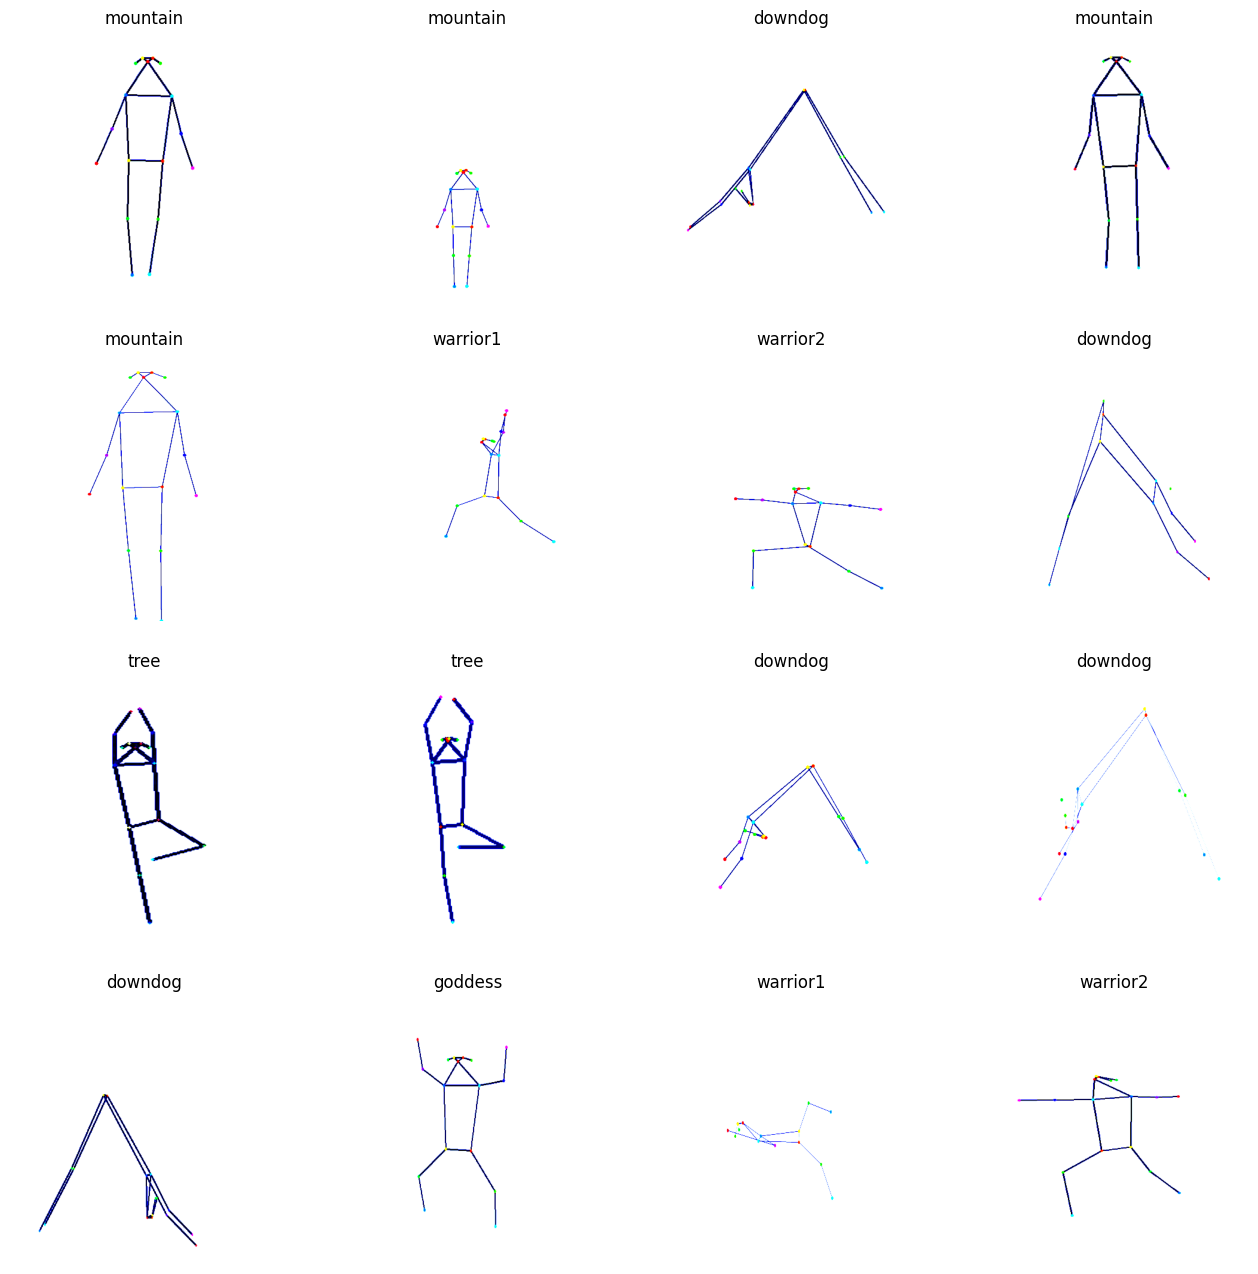

In [12]:
import matplotlib.pyplot as plt

# ImageFolder의 속성 값인 class_to_idx를 할당
#labels_map = {v:k for k, v in train_dataset.class_to_idx.items()}

figure = plt.figure(figsize=(16, 16))
cols, rows = 4, 4
images, labels = next(iter(train_loader))
# 이미지를 출력합니다. RGB 이미지로 구성되어 있습니다.
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title(le.classes_[label])
    plt.axis("off")
    # 본래 이미지의 shape은 (3, 300, 300) 입니다.
    # 이를 imshow() 함수로 이미지 시각화 하기 위하여 (300, 300, 3)으로 shape 변경을 한 후 시각화합니다.
    plt.imshow(torch.permute(img, (1, 2, 0)))
plt.show()

# 학습 및 검증 함수

In [13]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)

    best_score = 9999
    best_model = None

    for epoch in range(1, CFG['EPOCHS'] + 1):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            labels = labels.type(torch.LongTensor).to(device)  # ADDED .type(torch.LongTensor)

            optimizer.zero_grad()

            output = model(imgs)
            loss = criterion(output, labels)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val Weighted F1 Score : [{_val_score:.5f}]')
        
        if scheduler is not None:
            scheduler.step(_val_score)

        if best_score > _val_loss:
            # 모델 저장하기
            print("model save...")
            torch.save(model.state_dict(), "model1/eva_model_ggggg_large_nono_data_v1_{}_{}_{}".format(_train_loss,_val_loss,_val_score))
            best_score = _val_loss
            best_model = model

    return best_model

def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, true_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            labels = labels.type(torch.LongTensor).to(device)  # ADDED .type(torch.LongTensor)

            pred = model(imgs)

            loss = criterion(pred, labels)

            preds += pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += labels.detach().cpu().numpy().tolist()

            val_loss.append(loss.item())

        _val_loss = np.mean(val_loss)
        _val_score = f1_score(true_labels, preds, average='weighted')

    return _val_loss, _val_score

# 학습된 모델 불러오기

In [14]:
import timm

def freeze_pretrained_layers(model):
    '''Freeze all layers except the last layer(fc or classifier)'''
    for param in model.parameters():
        param.requires_grad = False
    model.head.weight.requires_grad = True
    model.head.bias.requires_grad = True

# timm/eva02_large_patch14_448.mim_m38m_ft_in1k
# 90.054	99.042	305.08	448

#eva02_base_patch14_448.mim_in22k_ft_in22k_in1k
#88.692	98.722	87.12	448

#eva02_small_patch14_336.mim_in22k_ft_in1k
#85.74	97.614	22.13	336
model_name = 'timm/eva02_large_patch14_448.mim_m38m_ft_in1k'
print("model load...")
print("model name : ", model_name)
model = timm.create_model(model_name, pretrained=True,num_classes = 256)  # 모델 정의, num_classes = len(le.classes_)

param_name = [name for name,_ in model.named_parameters()] # All parameters name
layer_name = [name for name,_ in model.named_modules()] # All layers name
freeze_pretrained_layers(model)
model._modules['head'] = torch.nn.Sequential(model._modules['head'],
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.modules.activation.ReLU(),
    torch.nn.Linear(in_features=256,
                    out_features=len(le.classes_), # same number of output units as our number of classes
                    bias=True)#,
    #torch.nn.modules.activation.Softmax()
).to(device)

#model.load_state_dict(torch.load("model1/eva_model_gg_large_nono_data_v1_0.0825039329187524_0.15323487110435963_0.9491094276462364"))

from torchinfo import summary
print(summary(model,
        input_size=(32, 3, CFG["IMG_SIZE"], CFG["IMG_SIZE"]), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
))


model load...
model name :  timm/eva02_large_patch14_448.mim_m38m_ft_in1k
Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Eva (Eva)                                [32, 3, 448, 448]    [32, 6]              1,050,624            Partial
├─PatchEmbed (patch_embed)               [32, 3, 448, 448]    [32, 1024, 1024]     --                   False
│    └─Conv2d (proj)                     [32, 3, 448, 448]    [32, 1024, 32, 32]   (603,136)            False
│    └─Identity (norm)                   [32, 1024, 1024]     [32, 1024, 1024]     --                   --
├─Dropout (pos_drop)                     [32, 1025, 1024]     [32, 1025, 1024]     --                   --
├─ModuleList (blocks)                    --                   --                   --                   False
│    └─EvaBlock (0)                      [32, 1025, 1024]     [32, 1025, 1024]     --                   False
│    │    └─LayerNorm (norm1)            [32, 

# 모델 학습

In [ ]:
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.85480] Val Loss : [0.41593] Val Weighted F1 Score : [0.88332]
model save...


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.33018] Val Loss : [0.31528] Val Weighted F1 Score : [0.89434]
model save...


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.25909] Val Loss : [0.27566] Val Weighted F1 Score : [0.90771]
model save...


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.22853] Val Loss : [0.25001] Val Weighted F1 Score : [0.91870]
model save...


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.19999] Val Loss : [0.24990] Val Weighted F1 Score : [0.91836]
model save...


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.18397] Val Loss : [0.22954] Val Weighted F1 Score : [0.92458]
model save...


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.16823] Val Loss : [0.22778] Val Weighted F1 Score : [0.92912]
model save...


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.15581] Val Loss : [0.21721] Val Weighted F1 Score : [0.92467]
model save...


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.14214] Val Loss : [0.21262] Val Weighted F1 Score : [0.93696]
model save...


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.13875] Val Loss : [0.21062] Val Weighted F1 Score : [0.94140]
model save...


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.12695] Val Loss : [0.23387] Val Weighted F1 Score : [0.92721]


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.12263] Val Loss : [0.21207] Val Weighted F1 Score : [0.93923]


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.11189] Val Loss : [0.20886] Val Weighted F1 Score : [0.93509]
Epoch 00013: reducing learning rate of group 0 to 1.5000e-04.
model save...


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.10244] Val Loss : [0.20664] Val Weighted F1 Score : [0.93498]
model save...


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.10252] Val Loss : [0.20569] Val Weighted F1 Score : [0.94128]
model save...


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.09660] Val Loss : [0.21268] Val Weighted F1 Score : [0.94549]


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.09834] Val Loss : [0.20506] Val Weighted F1 Score : [0.93924]
model save...


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.09258] Val Loss : [0.21635] Val Weighted F1 Score : [0.94541]


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.09323] Val Loss : [0.20991] Val Weighted F1 Score : [0.93697]
Epoch 00019: reducing learning rate of group 0 to 7.5000e-05.


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.08581] Val Loss : [0.20723] Val Weighted F1 Score : [0.94543]


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.08848] Val Loss : [0.20746] Val Weighted F1 Score : [0.93717]


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.08322] Val Loss : [0.20894] Val Weighted F1 Score : [0.94130]
Epoch 00022: reducing learning rate of group 0 to 3.7500e-05.


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.08194] Val Loss : [0.20817] Val Weighted F1 Score : [0.94128]


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.08591] Val Loss : [0.20808] Val Weighted F1 Score : [0.94337]


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.08193] Val Loss : [0.20742] Val Weighted F1 Score : [0.93923]
Epoch 00025: reducing learning rate of group 0 to 1.8750e-05.


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.07926] Val Loss : [0.20755] Val Weighted F1 Score : [0.94130]


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.08206] Val Loss : [0.20671] Val Weighted F1 Score : [0.94130]


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.08084] Val Loss : [0.20747] Val Weighted F1 Score : [0.94130]
Epoch 00028: reducing learning rate of group 0 to 9.3750e-06.


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.07938] Val Loss : [0.20761] Val Weighted F1 Score : [0.94130]


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [30], Train Loss : [0.07937] Val Loss : [0.20775] Val Weighted F1 Score : [0.94130]


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [31], Train Loss : [0.08035] Val Loss : [0.20772] Val Weighted F1 Score : [0.94130]
Epoch 00031: reducing learning rate of group 0 to 4.6875e-06.


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [32], Train Loss : [0.08071] Val Loss : [0.20762] Val Weighted F1 Score : [0.94130]


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [33], Train Loss : [0.07677] Val Loss : [0.20795] Val Weighted F1 Score : [0.94130]


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [34], Train Loss : [0.07912] Val Loss : [0.20822] Val Weighted F1 Score : [0.94130]
Epoch 00034: reducing learning rate of group 0 to 2.3437e-06.


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [35], Train Loss : [0.07857] Val Loss : [0.20816] Val Weighted F1 Score : [0.94130]


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [36], Train Loss : [0.07594] Val Loss : [0.20814] Val Weighted F1 Score : [0.94130]


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [37], Train Loss : [0.07597] Val Loss : [0.20821] Val Weighted F1 Score : [0.94130]
Epoch 00037: reducing learning rate of group 0 to 1.1719e-06.


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [38], Train Loss : [0.07638] Val Loss : [0.20815] Val Weighted F1 Score : [0.94130]


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [39], Train Loss : [0.07928] Val Loss : [0.20817] Val Weighted F1 Score : [0.94130]


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [40], Train Loss : [0.08053] Val Loss : [0.20819] Val Weighted F1 Score : [0.94130]
Epoch 00040: reducing learning rate of group 0 to 5.8594e-07.


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [41], Train Loss : [0.07752] Val Loss : [0.20810] Val Weighted F1 Score : [0.94130]


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [42], Train Loss : [0.08044] Val Loss : [0.20811] Val Weighted F1 Score : [0.94130]


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [43], Train Loss : [0.07824] Val Loss : [0.20810] Val Weighted F1 Score : [0.94130]
Epoch 00043: reducing learning rate of group 0 to 2.9297e-07.


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [44], Train Loss : [0.07743] Val Loss : [0.20809] Val Weighted F1 Score : [0.94130]


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [45], Train Loss : [0.07686] Val Loss : [0.20809] Val Weighted F1 Score : [0.94130]


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [46], Train Loss : [0.08076] Val Loss : [0.20809] Val Weighted F1 Score : [0.94130]
Epoch 00046: reducing learning rate of group 0 to 1.4648e-07.


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [47], Train Loss : [0.07958] Val Loss : [0.20809] Val Weighted F1 Score : [0.94130]


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [48], Train Loss : [0.07986] Val Loss : [0.20811] Val Weighted F1 Score : [0.94130]


  0%|          | 0/31 [00:00<?, ?it/s]

# 테스트 데이터 확인

In [ ]:
all_img_list = glob.glob('./test_1/*')
test_df = pd.DataFrame(columns=['img_path'])
test_df['img_path'] = all_img_list
test_dataset = CustomDataset(test_df['img_path'].values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)
def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)

            pred = model(imgs)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
    #preds = le.inverse_transform(preds)
    return preds

#infer_model = model
preds = inference(infer_model, test_loader, device)

test_df["int"] = 0
for i in range(len(test_df)):
    test_df["int"][i] = int(test_df["img_path"][i].split("\\")[1].split(".")[0])
test_df["pred"] = preds

test_df = test_df.sort_values(by='int' ,ascending=True).reset_index()
submit = pd.read_csv('./submission-example.csv')
submit['Category'] = test_df["pred"]

submit.to_csv('./test_2_v.3.csv', index=False)

# 카테고리 점수 추가

In [ ]:
all_img_list = glob.glob('./test_2/*')
test_df = pd.DataFrame(columns=['img_path'])
test_df['img_path'] = all_img_list
test_dataset = CustomDataset(test_df['img_path'].values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)


def inference(model, test_loader, device):
    model.eval()
    preds = []
    preds1 = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)

            pred = model(imgs)
            
            
            preds1 += pred.detach().cpu().numpy().tolist()
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
    return preds, preds1

#infer_model = model
preds, preds1 = inference(infer_model, test_loader, device)


test_df["int"] = 0
for i in range(len(test_df)):
    test_df["int"][i] = int(test_df["img_path"][i].split("\\")[1].split(".")[0])
test_df["pres"]=preds1

co=["p_0","p_1","p_2","p_3","p_4","p_5"]
for i in co:
    test_df[i]=0
for i in range(len(test_df)):
    for j in range(6):
        test_df[co[j]][i] = test_df["pres"][i][j]

test_df["pred"] = preds
test_df = test_df.sort_values(by='int' ,ascending=True).reset_index()
submit = pd.read_csv('./submission-example.csv')
submit['Category'] = test_df["pred"]
submit['Category_0'] = test_df["p_0"]
submit['Category_1'] = test_df["p_1"]
submit['Category_2'] = test_df["p_2"]
submit['Category_3'] = test_df["p_3"]
submit['Category_4'] = test_df["p_4"]
submit['Category_5'] = test_df["p_5"]

submit.to_csv('./eva_large_only_open_pose_data_augX_V_2.csv.csv', index=False)

In [81]:
submit

,Id,Category,Category_0,Category_1,Category_2,Category_3,Category_4,Category_5
0,0.jpg,5,-5.704985,-0.747600,-7.436171,-4.157773,3.489951,8.275233
1,1.jpg,0,8.320206,-1.290511,-5.262813,-5.652704,1.264594,-1.039062
2,2.jpg,5,-7.244302,1.763143,-6.797393,-3.045465,2.793030,6.527709
3,3.jpg,5,-5.117515,-0.359255,-5.751077,-3.735991,2.439512,7.119889
4,4.jpg,3,-4.131216,-1.858093,-0.740061,7.829154,-1.678780,-2.774042
...,...,...,...,...,...,...,...,...
384,384.jpg,5,-5.724097,0.940176,-7.632263,-4.276497,3.247102,7.220560
385,385.jpg,0,7.690808,-1.498418,-4.539127,-2.940175,0.232834,-2.065798
386,386.jpg,3,-4.511630,-3.391282,-0.356287,6.973456,-0.988272,-1.255774
387,387.jpg,2,-2.871567,-5.217938,3.599768,0.652970,2.036287,-1.338729


# voting

In [11]:
all_img_list = glob.glob('./eva*')
all_img_list

['.\\eva_large_only_open_pose.csv',
 '.\\eva_large_only_open_pose_data_augO_V_3.csv',
 '.\\eva_large_plus_open_pose_data_augO.csv',
 '.\\eva_large_plus_open_pose_data_augO_V_2.csv',
 '.\\eva_large_plus_open_pose_data_augO_V_3.csv',
 '.\\eva_large_plus_open_pose_data_augO_V_3.csv.csv',
 '.\\eva_small_only_open_pose_data_augO.csv',
 '.\\eva_small_only_open_pose_data_augX.csv']

In [12]:


submit1 = pd.read_csv(all_img_list[0])
submit2 = pd.read_csv(all_img_list[1])
submit3 = pd.read_csv(all_img_list[2])
submit4 = pd.read_csv(all_img_list[5])

In [13]:
a=["Category_0","Category_1","Category_2","Category_3","Category_4","Category_5"]
for i in a:
    submit1[i]=submit1[i]+submit2[i] + submit3[i]+submit4[i] # +


In [14]:
for i in range(len(submit1)):
    submit1["Category"][i] = submit1[a].iloc[i].argmax()

In [15]:
submit1.to_csv('./voting2.csv', index=False)